In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
REPO_NAME = 'sewer-nfl'
import sys, os
cwd = str(os.getcwd())
repo_dir = cwd[:cwd.find(REPO_NAME)+len(REPO_NAME)]
sys.path.insert(0,repo_dir)

In [3]:
import pandas as pd
import nfl_data_py as nflreadr

In [4]:
from warehouse.utilities.elo import calculate_elo_metric

In [5]:
api_data = nflreadr.import_pbp_data(range(2021,2023))

2021 done.
2022 done.
Downcasting floats.


In [6]:
api_data = api_data[api_data['week']<=18]

In [7]:
from warehouse.pipelines.pbp.involvement import player_involvement, player_involved, players_involved

In [8]:
player_involvement_df = player_involvement(pbp_data=api_data)

In [9]:
player_involved(player_involvement_df=player_involvement_df,
                #play_id = 40.0,
                #game_id = '2021_01_ARI_TEN',
                player_id = '00-0032560')

TypeError: player_involved() missing 2 required positional arguments: 'play_id' and 'game_id'

In [10]:
meta_columns = [
    'game_id',
    'old_game_id',
    'season',
    'week',
    'home_team',
    'away_team',
    'posteam',
    'spread_line'
]

play_columns = [
    'play_id',
    'play_type',
    'desc',
    'yards_gained',
    'passer_player_id',
    'receiver_player_id',
    'rusher_player_id',
    'offense_players',
    'defense_players'
]

epa_columns = [
    'epa',
    'air_epa',
    'yac_epa'
]

In [11]:
# Player Id Lookup function
rosters = nflreadr.import_rosters(years=[2020,2022])

In [12]:
r_columns = [
    'season',
    'week',
    'team',
    'position',
    'player_name',
    'player_id'
]
rosters[r_columns]

,season,week,team,position,player_name,player_id
0,2020,17,ARI,DB,Johnathan Joseph,00-0024239
1,2020,17,ARI,DB,Patrick Peterson,00-0027943
2,2020,17,ARI,DB,Prince Amukamara,00-0027957
3,2020,17,ARI,DB,Dre Kirkpatrick,00-0029560
4,2020,17,ARI,DB,Chris Banjo,00-0029747
...,...,...,...,...,...,...
2636,2022,18,WAS,WR,Antonio Gandy-Golden,00-0036340
2637,2022,18,WAS,WR,Dyami Brown,00-0036626
2638,2022,18,WAS,WR,Dax Milne,00-0036671
2639,2022,18,WAS,WR,Jahan Dotson,00-0037741


In [13]:
from scipy.stats import zscore

In [14]:
# Use to reduce outlier positions
position_filter = ['QB','RB','WR','TE']

dataset_cols = meta_columns + [
    'play_id',
    'play_type',
    'yards_gained',
    'rusher_player_id',
    'epa'
]

epa_dataset = api_data[dataset_cols]

mask = (epa_dataset['play_type']=='run')

epa_dataset = epa_dataset.loc[mask].merge(
    rosters[[
        'player_name',
        'position',
        'player_id'
        ]],
    left_on = ['rusher_player_id'],
    right_on = ['player_id'],
    how = 'inner'
).drop_duplicates()

position_mask = (epa_dataset['position'].isin(position_filter))

epa_dataset = epa_dataset[position_mask]

epa_dataset['defteam'] = epa_dataset.apply(lambda x : x['home_team'] if x['away_team']==x['posteam'] else x['away_team'], axis = 1)
# Pre-elo datasets should be at the game / team / player level

order_cols = ['season','week'] # Used in ELO function
off_gb_cols = ['posteam','defteam','position','rusher_player_id','player_name'] # At what level are we AGGREGATING offensive performance
gb_cols_z = ['season','position'] # What is aggregate level for z score
def_gb_cols = ['posteam','defteam','position'] # Matched up against what level on defense to AGGREGATE to
perf_cols = ['epa'] # What are we assessing for ELO

off_epa_dataset = epa_dataset.groupby(order_cols + off_gb_cols)[perf_cols].sum().reset_index()
for col in perf_cols:
    off_epa_dataset[f'z_{col}'] = off_epa_dataset.groupby(order_cols + gb_cols_z)[col].transform(lambda x : zscore(x))
off_epa_dataset.drop(perf_cols, axis = 1, inplace = True)

def_epa_dataset = epa_dataset.groupby(order_cols + def_gb_cols)[perf_cols].sum().reset_index()
for col in perf_cols:
    def_epa_dataset[f'z_{col}'] = def_epa_dataset.groupby(order_cols + gb_cols_z)[col].transform(lambda x : zscore(x))
def_epa_dataset.drop(perf_cols, axis = 1, inplace = True)

# Don't need to use cumulative functions, because this is retroactive and we can use long term averages by position
#  epa_dataset[[f'cum_{col}' for col in perf_cols]] = epa_dataset.groupby(off_gb_cols_cum)[perf_cols].cumsum()
# epa_dataset['cum_n'] = epa_dataset.groupby(off_gb_cols_cum)[perf_cols[0]].cumcount()
# for col in perf_cols:
#     epa_dataset[f'cummean_{col}'] = epa_dataset[f'cum_{col}'] / (epa_dataset['cum_n'] + 1)
# # Calculate standard deviation
# epa_dataset.groupby(off_gb_cols_cum)['yards_gained'].expanding().std()

In [30]:
def_appearance_columns = ['defteam','position']
def_epa_dataset['def_appearance'] = def_epa_dataset.sort_values(order_cols).groupby(def_appearance_columns)['posteam'].cumcount() + 1

off_appearance_columns = ['position','rusher_player_id']
off_epa_dataset['off_appearance'] = off_epa_dataset.sort_values(order_cols).groupby(off_appearance_columns)['defteam'].cumcount() + 1

In [186]:
def_epa_dataset.to_csv('off.csv')

In [279]:
from warehouse.utilities.elo import calculate_elo_metric

elo_df = calculate_elo_metric(
    input_off_data = off_epa_dataset,
    input_def_data = def_epa_dataset,
    elo_multiplier = 10,
    elo_power = 1.5 # Should be somewhere between 1 and 2
)

In [280]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 2]

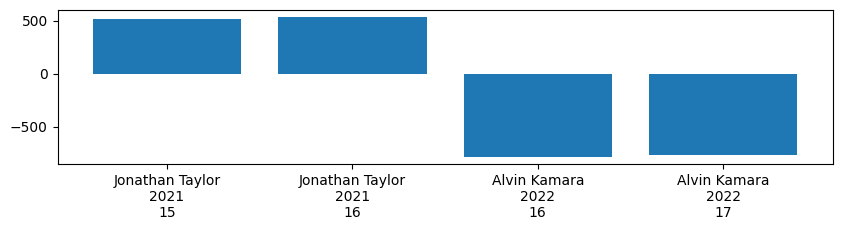

<Figure size 4000x200 with 0 Axes>

In [284]:
pos = 'RB'
asc = True
N = 2

view = elo_df[elo_df['position']==pos].sort_values('off_elo', ascending=asc)[['season','week','player_name','off_elo']].drop_duplicates()
top_rows = view.iloc[-N:]
bottom_rows = view.iloc[:N]

bar = pd.concat([top_rows,bottom_rows])
bar['season'] = bar['season'].astype(str)
bar['week'] = bar['week'].astype(str)
bar['ind'] = bar[['player_name','season', 'week']].agg('\n'.join, axis=1)

plt.bar(bar['ind'], bar['off_elo'] - 2000, align='center')
plt.figure().set_figwidth(40)
plt.show()

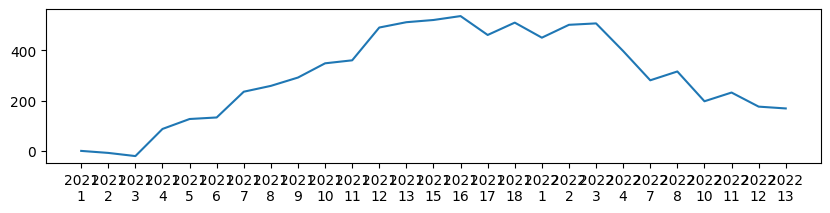

In [285]:
player_name = 'Jonathan Taylor'

view = elo_df[elo_df['player_name']==player_name]
view['season'] = view['season'].astype(str)
view['week'] = view['week'].astype(str)
view['ind'] = view[['season', 'week']].agg('\n'.join, axis=1)

plt.plot(view['ind'], view['off_elo'] - 2000)